## Modeling of the GPS assay

Global Protein Stability (GPS) assay measures the relative stability or instability of GFP conferred by the addition of a 23 amino acid protein. In this notebook, we evaluate different computational methods to predict the results of the GPS assay.

In [1]:
# import needed python packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import utils

### C-terminal GPS assay

The C-terminal GPS assay systematically attached the last 23 amino acids of each protein in the proteome to GFP to measure the relative stability/instability conferred to GFP.

#### Performance evaluation

First, we evaluate the performance of deepDegron at predicting the GPS assay.

In [2]:
# read in test set predictions
deepDegron = pd.read_csv('data/GPS/cterm_deepDegron/test_set_predictions.txt', sep='\t')
rf = pd.read_csv('data/GPS/cterm_random_forest/test_set_predictions.txt', sep='\t')
# read in rule-based approaches by Koren et al.
train_x, test_x, train_y, test_y = utils.rule_based()

# merge the data together
test_set = deepDegron.rename(columns={'prediction': 'deepDegron'})
test_set['Random Forest'] = rf.prediction.values
test_set['bulky aa'] = test_x['bulky'].values
test_set['acidic aa'] = test_x['acidic'].values
test_set['top 100 motifs'] = test_x['simple motif'].values

Next, we also include a model that combines the three rule-based approaches: bulky amino acids, acidic amino acids, and top 100 motifs.

In [3]:
from sklearn.linear_model import LogisticRegression

# combine rule based approaches together using logistic regression
rule_based_approaches = ['bulky', 'acidic', 'simple motif']
fit = LogisticRegression().fit(train_x[rule_based_approaches], train_y)
lr_pred = fit.predict_proba(test_x[rule_based_approaches])[:,1]

# add predictions to test results
test_set['Logistic Regression'] = lr_pred

Next, we evaluate the performance of the different approaches.

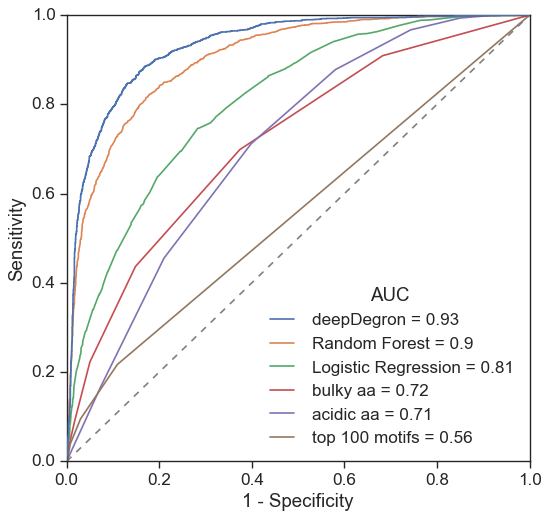

In [4]:
import sklearn.metrics as metrics

cols = ['deepDegron', 'Random Forest', 'Logistic Regression', 
        'bulky aa', 'acidic aa', 'top 100 motifs']
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.4):
    # plot each methods performance
    for col in cols:
        roc_auc = metrics.roc_auc_score(test_set['y'], test_set[col])
        fpr, tpr, thresholds = metrics.roc_curve(test_set['y'], test_set[col])
        z = 10 if col=='deepDegron' else 0
        plt.plot(fpr, tpr, label='{0} = {1:.2g}'.format(col, roc_auc), zorder=z)
        plt.ylabel('Sensitivity')
        plt.xlabel('1 - Specificity')
        plt.legend(loc='best', title='AUC', frameon=False)
    
    # add random chance line
    plt.plot([0, 1], [0, 1], color='gray', ls='--')
    
    # savefigure
    plt.tight_layout()
    plt.gcf().set_size_inches(7,7)
    plt.savefig('figures/cterm_degron_roc.pdf')

#### Comparison to saturation mutagenesis

Next, we compare our predictions to a saturation mutagenesis experiment done on EPHB2 peptide sequence.

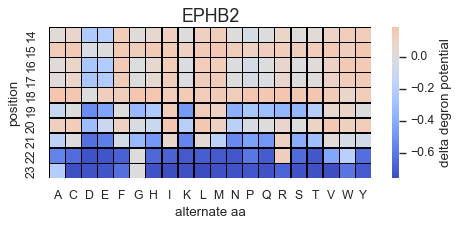

In [6]:
ephb2_df = pd.read_table('data/GPS/saturation_mutagenesis/cterm/EPHB2.txt')
ephb2_df['alt'] = ephb2_df['Substitution'].str[-1:]
ephb2_df['ref'] = ephb2_df['Substitution'].str[:1]
ephb2_df['pos'] = ephb2_df['Substitution'].str[1:-1].astype(int)
baseline = ephb2_df[ephb2_df['ref']==ephb2_df['alt']]['degron potential'].iloc[0]
heatmap = pd.pivot_table(index='alt', columns='pos', values='degron potential', data=ephb2_df)
g = sns.heatmap(heatmap.T-baseline,linewidths=0.3, linecolor='black',
                cbar_kws={'label': 'delta degron potential'},
                cmap='coolwarm',
                center=0
                #cmap=sns.cubehelix_palette(16, start=.5, rot=-.75),
               )

plt.gcf().set_size_inches((6, 3))
plt.title('EPHB2', size=16)
plt.xlabel('alternate aa')
plt.ylabel('position')
plt.tight_layout()
plt.savefig('figures/EPHB2_cterm_mutagenesis.pdf')

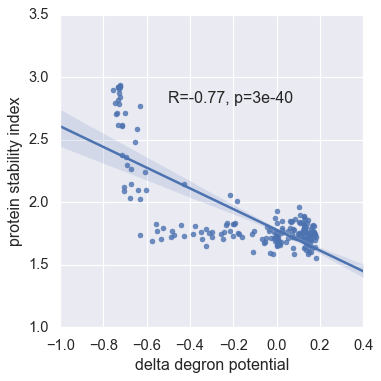

In [7]:
ephb2_df['delta degron potential'] = ephb2_df['degron potential'] - baseline
with sns.plotting_context('notebook', font_scale=1.2):
    sns.lmplot('delta degron potential', 'PSI', data=ephb2_df)
    r, pval = stats.pearsonr(ephb2_df['delta degron potential'], ephb2_df['PSI'])
    plt.text(-.5, 2.8, 'R={0:.2g}, p={1:.2g}'.format(r, pval))
    plt.ylabel('protein stability index')
    plt.savefig('figures/EPHB2_cterm_corr.pdf')

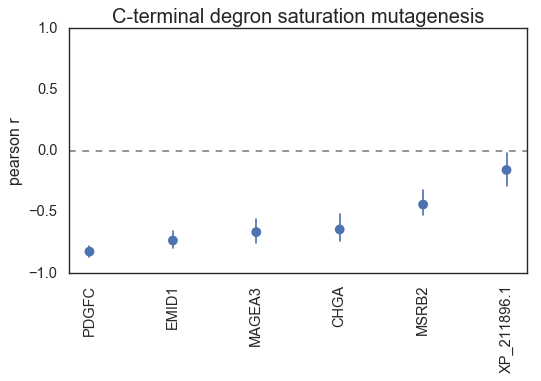

In [9]:
summary_df = utils.create_sat_mutagenesis_summary('data/GPS/saturation_mutagenesis/cterm/')
summary_df = summary_df[summary_df['gene']!='EPHB2']  # skip the one that was already looked at
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.2):
    sns.pointplot(x=summary_df['gene'], y=summary_df['pearson r'], join=False, size=.5)
    i=0
    for ix, row in summary_df.iterrows():
        plt.plot([i, i], [row['upper'], row['lower']], color=sns.color_palette()[0])
        i += 1
    plt.ylim(-1, 1)
    plt.axhline(0, ls='--', color='gray')
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.title('C-terminal degron saturation mutagenesis', size=18)
    plt.gcf().set_size_inches(7, 5)
    plt.tight_layout()
    plt.savefig('figures/cterminal_saturation_mutagenesis.pdf')

### N-terminal GPS assay

The N-terminal GPS assay systematically attached the first 24 (23 without methioinine) amino acids of each protein in the proteome to the n-terminus of GFP to measure the relative stability/instability conferred to GFP.

#### Performance evaluation

First, we evaluate the performance of deepDegron at predicting the GPS assay.

In [10]:
# read in test set predictions
deepDegron = pd.read_csv('data/GPS/nterm_deepDegron/test_set_predictions.txt', sep='\t')
rf = pd.read_csv('data/GPS/nterm_random_forest/test_set_predictions.txt', sep='\t')
# read in rule-based approaches by Koren et al.
train_x, test_x, train_y, test_y = utils.rule_based(
    data_path='data/GPS/nterm_deepDegron/nterm_degron_predictions.txt', 
    top100_path='data/GPS/nterm_degron_koren_et_al_rule_based.txt',
    motif_type='nterm'
)

# merge the data together
test_set = deepDegron.rename(columns={'prediction': 'deepDegron'})
test_set['Random Forest'] = rf.prediction.values
test_set['bulky aa'] = test_x['bulky'].values
test_set['acidic aa'] = test_x['acidic'].values
test_set['top 100 motifs'] = test_x['simple motif'].values

Next, we also include a model that combines the three rule-based approaches: bulky amino acids, acidic amino acids, and top 100 motifs.

In [11]:
from sklearn.linear_model import LogisticRegression

# combine rule based approaches together using logistic regression
rule_based_approaches = ['bulky', 'acidic', 'simple motif']
fit = LogisticRegression().fit(train_x[rule_based_approaches], train_y)
lr_pred = fit.predict_proba(test_x[rule_based_approaches])[:,1]

# add predictions to test results
test_set['Logistic Regression'] = lr_pred

Next, we evaluate the performance of the different approaches.

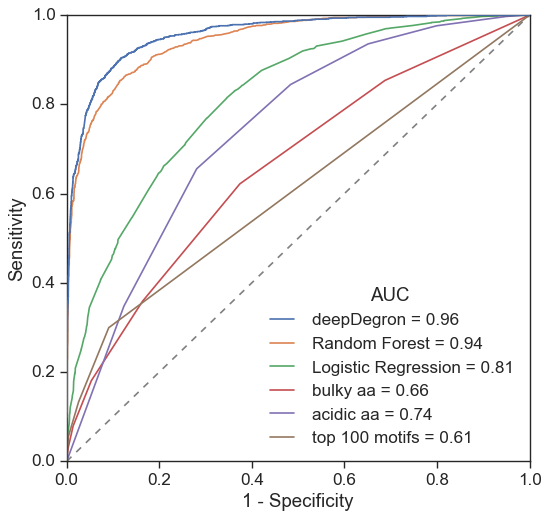

In [12]:
import sklearn.metrics as metrics

cols = ['deepDegron', 'Random Forest', 'Logistic Regression', 
        'bulky aa', 'acidic aa', 'top 100 motifs']
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.4):
    # plot each methods performance
    for col in cols:
        roc_auc = metrics.roc_auc_score(test_set['y'], test_set[col])
        fpr, tpr, thresholds = metrics.roc_curve(test_set['y'], test_set[col])
        z = 10 if col=='deepDegron' else 0
        plt.plot(fpr, tpr, label='{0} = {1:.2g}'.format(col, roc_auc), zorder=z)
        plt.ylabel('Sensitivity')
        plt.xlabel('1 - Specificity')
        plt.legend(loc='best', title='AUC', frameon=False)
    
    # add random chance line
    plt.plot([0, 1], [0, 1], color='gray', ls='--')
    
    # savefigure
    plt.tight_layout()
    plt.gcf().set_size_inches(7, 7)
    plt.savefig('figures/nterm_degron_roc.pdf')

#### Comparison to saturation mutagenesis

Next, we compare our predictions to a saturation mutagenesis experiment done on n-terminal peptide sequence.

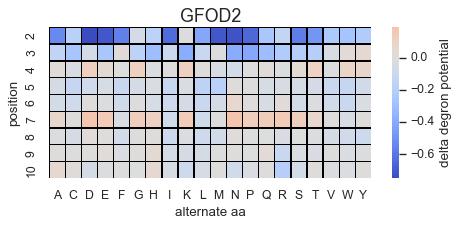

In [13]:
gene = 'GFOD2'
score_df = pd.read_table('data/GPS/saturation_mutagenesis/nterm/{}.txt'.format(gene))
score_df = utils.process_df(score_df)
heatmap = pd.pivot_table(index='alt', columns='pos', 
                         values='delta degron potential', data=score_df)
g = sns.heatmap(heatmap.T,linewidths=0.3, linecolor='black',
                cbar_kws={'label': 'delta degron potential'},
                center=0,
                cmap='coolwarm',
                #cmap=sns.cubehelix_palette(16, start=.5, rot=-.75)
               )

plt.gcf().set_size_inches((6, 3))
plt.title(gene, size=16)
plt.xlabel('alternate aa')
plt.ylabel('position')
plt.tight_layout()

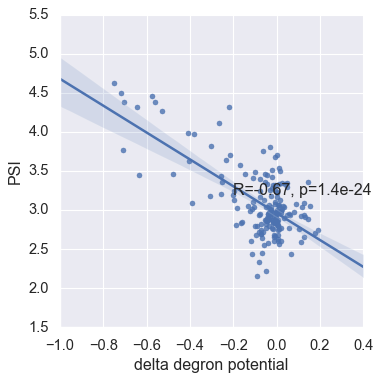

In [14]:
with sns.plotting_context('notebook', font_scale=1.2):
    g = sns.lmplot('delta degron potential', 'PSI', data=score_df)
    r, pval = stats.pearsonr(score_df['delta degron potential'], score_df['PSI'])
    plt.text(-.2, 3.2, 'R={0:.2g}, p={1:.2g}'.format(r, pval))

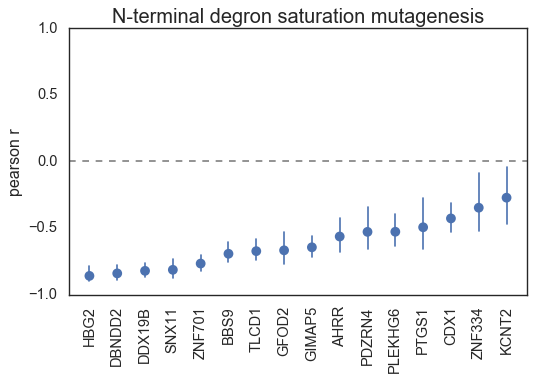

In [17]:
summary_df = utils.create_sat_mutagenesis_summary('data/GPS/saturation_mutagenesis/nterm/')
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.2):
    sns.pointplot(x=summary_df['gene'], y=summary_df['pearson r'], join=False, size=.5)
    i=0
    for ix, row in summary_df.iterrows():
        plt.plot([i, i], [row['upper'], row['lower']], color=sns.color_palette()[0])
        i += 1
    plt.ylim(-1, 1)
    plt.axhline(0, ls='--', color='gray')
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.title('N-terminal degron saturation mutagenesis', size=18)
    plt.gcf().set_size_inches(7, 5)
    plt.tight_layout()
    plt.savefig('figures/nterminal_saturation_mutagenesis.pdf')

### Supplementary tables

In [4]:
# read in all the predictions from the c-terminal and n-terminal GPS assays
rename_dict = {'sequence position specific': 'position specific', 'bag of words': 'bag of amino acids',
               'regulatory potential': 'degron potential', 'Ensembl Transcript ID': 'Transcript_ID'}
nterm = pd.read_table('data/GPS/nterm_deepDegron/nterm_degron_predictions.txt')
nterm = nterm.rename(columns=rename_dict).sort_values('degron potential', ascending=False)
cterm = pd.read_table('data/GPS/cterm_deepDegron/cterm_degron_predictions.txt')
cterm = cterm.rename(columns=rename_dict).sort_values('degron potential', ascending=False)


Now save the predictions to a file.

In [13]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('tables/TableS7.xlsx', engine='xlsxwriter')

# save sheets
cterm_cols = ['Gene_ID', 'Transcript_ID', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Modal Bin', 
              'PSI', 'Peptide amino acid sequence', 'position specific', 'bag of amino acids', 
              'degron potential']
cterm[cterm_cols].to_excel(writer, sheet_name='c-terminal', float_format='%.2G', index=False)
nterm_cols = ['Gene_ID', 'Transcript_ID', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5', 'Bin6', 'Modal Bin', 
              'PSI', 'Peptide amino acid sequence', 'position specific', 'bag of amino acids', 
              'degron potential']
nterm[nterm_cols].to_excel(writer, sheet_name='n-terminal', float_format='%.2G', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [17]:
cterm.head()

,Transcript_ID,Gene_ID,Bin1,Bin2,Bin3,Bin4,Modal Bin,PSI,Bin1_MLN4924,Bin2_MLN4924,CRL substrate?,Peptide amino acid sequence,position specific,bag of amino acids,degron potential
5605,NP_005898.2,MAN1A1,792.36,1066.29,212.08,185.04,2,1.91,7076.92,26086.61,YES,FNSEAHLLPILPKDKKEVEIREE,0.916590,0.056313,0.860278
14358,NP_689899.1,DNAJC18,1515.83,161.56,126.50,124.48,1,1.41,9845.28,792.98,YES,KAESLKLENCEKLSKLIGLRRGG,0.983706,0.151017,0.832689
7932,NP_055859.1,GGA2,780.88,1023.21,267.88,181.67,2,1.93,244.03,0.00,NaN,GGQPFSEVGEVKDFPDLAVLGAA,0.934750,0.108256,0.826494
23,NP_000031.1,APOC3,6656.62,1482.76,1518.01,1392.83,1,1.79,2048.27,253.75,NaN,VKDKFSEFWDLDPEVRPTSAVAA,0.946566,0.138486,0.808080
8485,NP_057125.2,DERL2,1404.82,2825.50,721.80,427.27,2,2.03,9317.21,49191.64,YES,NYNPLPEERPGGFAWGEGQRLGG,0.875227,0.091667,0.783561


### Save motif instances for creating sequence logos

In [36]:
cterm_motifs = pd.read_csv('data/motif_enrichment/cterm/dimotif.txt', sep='\t')
top_cterm_motifs = cterm_motifs['motif'].head(20).values
num_top = cterm_motifs['top total'].iloc[0]

In [37]:
for i, m in enumerate(top_cterm_motifs):
    is_cgc = cterm['Peptide amino acid sequence'].head(num_top).apply(utils.motif_count, args=([m], 'cterm'))
    cols = ['Gene_ID', 'Peptide amino acid sequence', 'PSI', 'degron potential', 'position specific' ,'Modal Bin']
    cterm.head(num_top).loc[(is_cgc>0), cols]['PSI'].mean() # 'Peptide amino acid sequence'
    print(m)
    outstr = '\n'.join(cterm.head(num_top).loc[is_cgc>0,'Peptide amino acid sequence'].str[-6:].values)
    with open('results/cterm_motifs/{}_{}.txt'.format(i+1, m), 'w') as write_handle:
        write_handle.write(outstr)

xxxxEE
xxxxVS
xxxxAA
xxxxCR
xxxxRG
xxxxVC
xxxxKA
xLxRxx
xxCxCx
xxxxAT
xxxAAx
xxxRxA
xLxxxG
xxxxGG
xxxxAF
xLxxAx
xSxxxG
xLxxxA
xxSxVx
xxxxSG


In [46]:
nterm_motifs = pd.read_csv('data/motif_enrichment/nterm/dimotif.txt', sep='\t')
top_nterm_motifs = nterm_motifs['motif'].head(50).values
num_top = nterm_motifs['top total'].iloc[0]
nterm_copy = nterm.head(num_top).copy()

In [47]:
for i, m in enumerate(top_nterm_motifs):
    is_cgc = nterm_copy['Peptide amino acid sequence'].apply(utils.motif_count, args=([m], 'nterm'))
    cols = ['Gene_ID', 'Peptide amino acid sequence', 'PSI', 'degron potential', 'position specific' ,'Modal Bin']
    nterm_copy.loc[(is_cgc>0), cols]['PSI'].mean() # 'Peptide amino acid sequence'
    print(m)
    outstr = '\n'.join(nterm_copy.loc[is_cgc>0,'Peptide amino acid sequence'].str[:6].values)
    with open('results/nterm_motifs/{}_{}.txt'.format(i+1, m), 'w') as write_handle:
        write_handle.write(outstr)

GAxxxx
GxxxxR
GxLxxx
GGxxxx
GPxxxx
APxxxx
GxxGxx
GxxRxx
GxxxxE
GxxxAx
GxGxxx
GxxxRx
PPxxxx
GxxxFx
GLxxxx
GxxxLx
GFxxxx
GxxxxS
GxxAxx
GxQxxx
GxxSxx
GxxxxP
xPLxxx
GxTxxx
GVxxxx
GRxxxx
GxxTxx
GxxxxQ
GxxxVx
GxxxSx
GxxxxA
RxxPxx
GxSxxx
GxRxxx
GxxVxx
GxAxxx
GxKxxx
xPxxxR
GHxxxx
GIxxxx
RxRxxx
GxxxxV
RxxxxG
CxxxSx
xxLxxR
GxxDxx
GxxxGx
GxxxxG
GMxxxx
CxxxxS
